## Setup

In [3]:
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelBinarizer

# Function to set random seed
def set_random_seed(seed=42):
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
set_random_seed()

In [4]:
# Load the MNIST dataset
(data_train, labels_train), (data_test, labels_test) = tf.keras.datasets.mnist.load_data()

# Flatten the dataset
data_train = data_train.reshape(len(data_train), -1)
data_test = data_test.reshape(len(data_test), -1)

# Combine the dataset
data = np.r_[data_train, data_test]
labels = np.r_[labels_train, labels_test]

# Scale the inputs
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Create one-hot labels
binarizer = LabelBinarizer()
labels_one_hot = binarizer.fit_transform(labels)

# Shuffle the dataset
shuffled_indices = np.random.permutation(len(data))
data = data[shuffled_indices]
labels = labels[shuffled_indices]
labels_one_hot = labels_one_hot[shuffled_indices]

# Split the dataset
train_ratio = 0.9
split_index = int(train_ratio * len(data))
data_train = data[:split_index]
labels_train = labels[:split_index]
data_test = data[split_index:]
labels_test = labels[split_index:]
labels_train_one_hot = labels_one_hot[:split_index]
labels_test_one_hot = labels_one_hot[split_index:]

print(data_train.shape, labels_train.shape, data_test.shape, labels_test.shape)

/home/ice-bear/anaconda3/envs/machine_learning/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(63000, 784) (63000,) (7000, 784) (7000,)


In [5]:
# Generator to fetch a portion of the dataset(
def fetch_batch(X, y, batch_size):
    shuffled_indices = np.random.permutation(len(X))
    for i in range(0, len(X), batch_size):
        X_batch = X[shuffled_indices[i:i+batch_size]]
        y_batch = y[shuffled_indices[i:i+batch_size]]
        yield X_batch, y_batch

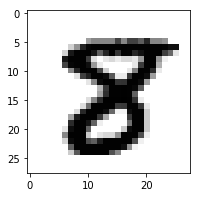

In [8]:
# Function to display one MNIST data
def plot_digit(x):
    plt.figure(figsize=(3,3))
    x = scaler.inverse_transform(x)
    x = x.reshape(28, 28)
    plt.imshow(x, cmap=matplotlib.cm.binary)
    plt.show()
    
plot_digit(data_train[0])

In [9]:
# The logistic function
def sigmoid(X):
    return 1.0 / (1.0 + np.exp(-X))

# The softmax function
def softmax(X, axis=-1):
    return np.exp(X) / np.sum(np.exp(X), axis=axis, keepdims=True)

## LeNet-5

In [10]:
class LeNet5:
    def __init__(self, learning_rate=0.1, momentum=0.5, dropout_rate=0.5):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.dropout_rate = dropout_rate
        
    def build_graph(self):
        # MNIST properties
        height = 28
        width = 28
        channels = 1
        input_size = height * width * channels
        output_size = 10
        
        # Build the graph
        self.graph = tf.Graph()
        with self.graph.as_default():
            # Make input placeholders
            self.X_ph = tf.placeholder(shape=(None, input_size), dtype=tf.float32)
            X_reshaped = tf.reshape(self.X_ph, shape=(-1, height, width, channels))
            self.y_ph = tf.placeholder(shape=(None,), dtype=tf.int32)
            self.train_ph = tf.placeholder(shape=(), dtype=tf.bool)
            
            # First convolutional layer
            X = tf.layers.conv2d(X_reshaped, filters=6, kernel_size=5, strides=1, 
                                 padding='SAME', activation=tf.nn.tanh)
            
            # First pooling layer
            X = tf.nn.avg_pool(X, ksize=(1,2,2,1), strides=(1,2,2,1), padding='VALID')
            
            # Second convolutional layer
            X = tf.layers.conv2d(X, filters=16, kernel_size=5, strides=1,
                                 padding='VALID', activation=tf.nn.tanh)
            
            # Second pooling layer
            X = tf.nn.avg_pool(X, ksize=(1,2,2,1), strides=(1,2,2,1), padding='VALID')
            
            # Third convolutional layer
            X = tf.layers.conv2d(X, filters=120, kernel_size=5, strides=1,
                                 padding='VALID', activation=tf.nn.tanh)
            
            # Fully connected layers
            X = tf.reshape(X, shape=(-1, 120))
            X = tf.layers.dropout(X, rate=self.dropout_rate, training=self.train_ph)
            X = tf.layers.dense(X, units=84, activation=tf.nn.tanh)
            X = tf.layers.dropout(X, rate=self.dropout_rate, training=self.train_ph)
            self.logits = tf.layers.dense(X, units=output_size)
            
            # Probabilities for each class
            self.probs = tf.nn.softmax(self.logits, axis=1)
            
            # Use mean cross entropy as the loss function
            cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.logits, labels=self.y_ph)
            self.loss = tf.reduce_mean(cross_entropy)
            
            # Make optimizer and train op
            optimizer = tf.train.MomentumOptimizer(learning_rate=self.learning_rate, momentum=self.momentum)
            self.train_op = optimizer.minimize(self.loss)
            
            # Variables initializer
            self.init = tf.global_variables_initializer()
            
        self.sess = tf.Session(graph=self.graph)
        self.sess.run(self.init)
            
        return self.graph
            
    def train(self, X, y, batch_size=100, n_epochs=1, show_progress=False):
        for epoch in range(n_epochs):
            # Perform mini-batch gradient descent using the entire dataset
            for X_batch, y_batch in fetch_batch(X, y, batch_size):
                self.sess.run(self.train_op, feed_dict={self.X_ph: X_batch, 
                                                        self.y_ph: y_batch, 
                                                        self.train_ph: True})
                
            if show_progress:
                prediction = self.predict(X[:1000])
                accuracy = sum(prediction == y[:1000]) / 1000
                print("Epoch: %d \t Train accuracy: %.3f" % (epoch, accuracy))
                    
    def predict(self, X):
        logits = self.sess.run(self.logits, feed_dict={self.X_ph: X, self.train_ph: False})
        return np.argmax(logits, axis=1)
        
    def get_probs(self, X):
        probs = self.sess.run(self.probs, feed_dict={self.X_ph: X, self.train_ph: False})
        return probs
    
    def reset_session(self):
        self.sess.close()
        self.sess = tf.Session(graph=self.graph)
            
    def __del__(self):
        self.sess.close()

In [11]:
set_random_seed(42)

lenet5 = LeNet5(learning_rate=0.1, momentum=0.5, dropout_rate=0.5)

t = time.time()
lenet5.build_graph()
print("Time to build graph: %.3f s" % (time.time() - t))

t = time.time()
lenet5.train(data_train, labels_train, n_epochs=25, show_progress=True)
print("Time to train model: %.3f s" % (time.time() - t))

prediction = lenet5.predict(data_test)

print("Test accuracy:", sum(prediction==labels_test) / len(labels_test))

Time to build graph: 0.419 s
Epoch: 0 	 Train accuracy: 0.955
Epoch: 1 	 Train accuracy: 0.974
Epoch: 2 	 Train accuracy: 0.979
Epoch: 3 	 Train accuracy: 0.979
Epoch: 4 	 Train accuracy: 0.982
Epoch: 5 	 Train accuracy: 0.991
Epoch: 6 	 Train accuracy: 0.987
Epoch: 7 	 Train accuracy: 0.991
Epoch: 8 	 Train accuracy: 0.985
Epoch: 9 	 Train accuracy: 0.992
Epoch: 10 	 Train accuracy: 0.987
Epoch: 11 	 Train accuracy: 0.994
Epoch: 12 	 Train accuracy: 0.990
Epoch: 13 	 Train accuracy: 0.991
Epoch: 14 	 Train accuracy: 0.995
Epoch: 15 	 Train accuracy: 0.992
Epoch: 16 	 Train accuracy: 0.994
Epoch: 17 	 Train accuracy: 0.991
Epoch: 18 	 Train accuracy: 0.994
Epoch: 19 	 Train accuracy: 0.995
Epoch: 20 	 Train accuracy: 0.995
Epoch: 21 	 Train accuracy: 0.994
Epoch: 22 	 Train accuracy: 0.996
Epoch: 23 	 Train accuracy: 0.993
Epoch: 24 	 Train accuracy: 0.996
Time to train model: 408.161 s
Test accuracy: 0.9897142857142858


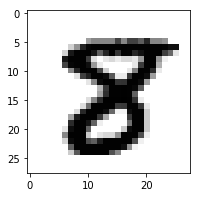

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


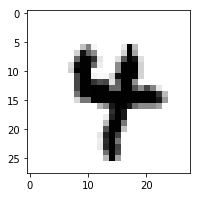

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


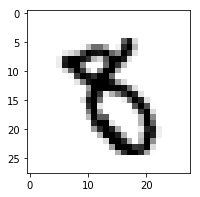

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


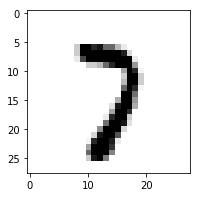

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


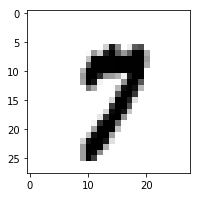

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [12]:
# Use the trained CNN to generate target probabilities
cnn_probs = lenet5.get_probs(data_train)

# Show some examples to make sure everything's okay
for i in range(5):
    plot_digit(data_train[i])
    print(np.around(cnn_probs[i],2))

## Soft Decision Tree

In [13]:
class SoftDecisionTree:
    def __init__(self, max_depth=1, learning_rate=0.1, momentum=0.1, inverse_temperature=1.0, reg_fn=None):
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.inverse_temperature = inverse_temperature
        if reg_fn: 
            self.reg_fn = reg_fn
        else:
            self.reg_fn = lambda d: 0  # no regularization
    
    def build_node(self, X, y, path_probs, current_depth=1, index=1):
        if current_depth == self.max_depth:
            # Build a leaf node
            self.leaf_logits[index] = tf.Variable(initial_value=np.random.randn(y.shape[1], 1), dtype=tf.float32)
            
            probs = tf.nn.softmax(self.leaf_logits[index], axis=0)
            
            cross_entropy = tf.squeeze(tf.matmul(y, tf.log(probs)), axis=1)
            weighted_cross_entropy = tf.multiply(path_probs, cross_entropy)
            
            self.loss = self.loss + tf.reduce_mean(weighted_cross_entropy)
        else:
            # Build an internal node
            self.weights[index] = tf.Variable(initial_value=np.random.randn(X.shape[1], 1), dtype=tf.float32)
            self.bias[index] = tf.Variable(initial_value=0.0)
            
            logits = tf.matmul(X, self.weights[index]) + self.bias[index]
            
            probs = tf.squeeze(tf.sigmoid(self.inverse_temperature * logits), axis=1)
            
            path_probs_left = tf.multiply(path_probs, 1-probs)
            path_probs_right = tf.multiply(path_probs, probs)
            
            # Add regularization term (balanced split)
            epsilon = tf.constant(1e-8)
            reg_term = self.reg_fn(current_depth)
            left_ratio = tf.reduce_sum(path_probs_left) / (tf.reduce_sum(path_probs) + epsilon)
            right_ratio = tf.reduce_sum(path_probs_right) / (tf.reduce_sum(path_probs) + epsilon)
            
            self.loss = self.loss + reg_term * (0.5 * tf.log(left_ratio + epsilon) + 0.5 * tf.log(right_ratio + epsilon))
            
            # Build left and right subtrees
            self.build_node(X, y, path_probs_left, current_depth+1, 2*index)
            self.build_node(X, y, path_probs_right, current_depth+1, 2*index+1)
            
    def build_graph(self):
        # MNIST properties
        input_size = 28 * 28
        output_size = 10
        
        # Create lists for storing parameters
        n_nodes = 2 ** (self.max_depth + 1)
        self.weights = [0] * n_nodes
        self.bias = [0] * n_nodes
        self.leaf_logits = [0] * n_nodes
        
        # Build the graph
        self.graph = tf.Graph()
        with self.graph.as_default():
            # Make input placeholders
            self.X_ph = tf.placeholder(shape=(None, input_size), dtype=tf.float32)
            self.y_ph = tf.placeholder(shape=(None, output_size), dtype=tf.float32)
            
            # Initialize the loss function
            self.loss = 0
            
            # Start building from the root node
            batch_size = tf.shape(self.X_ph)[0]
            self.build_node(self.X_ph, self.y_ph, tf.fill([batch_size], 1.0))
            
            # Finalize the loss function
            self.loss = -self.loss
            
            # Make optimizer and train op
            # optimizer = tf.train.MomentumOptimizer(learning_rate=self.learning_rate, momentum=self.momentum)
            optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
            self.train_op = optimizer.minimize(self.loss)
            
            # Variables initializer
            self.init = tf.global_variables_initializer()
            
        self.sess = tf.Session(graph=self.graph)
        self.sess.run(self.init)
            
        return self.graph
            
    def train(self, X, y, batch_size=100, n_epochs=1, show_progress=False, predict_method=1):
        for epoch in range(n_epochs):
            # Perform mini-batch gradient descent using the entire dataset
            for X_batch, y_batch in fetch_batch(X, y, batch_size):
                self.sess.run(self.train_op, feed_dict={self.X_ph: X_batch, self.y_ph: y_batch})
                # print("Loss", self.sess.run(self.loss, feed_dict={self.X_ph: X_batch, self.y_ph: y_batch}))
                
            if show_progress:
                prediction = self.predict(X[:1000], method=predict_method)
                accuracy = sum(prediction == np.argmax(y[:1000], axis=1)) / 1000
                print("Epoch: %d \t Train accuracy: %.3f" % (epoch, accuracy))
                   
    def get_logits_local(self, X, current_depth=1, index=1):
        # At each internal node, split the samples into two based on the 
        # computed probability at that node only
        # print("Logits local")
        if len(X) == 0:
            return None
        elif current_depth == self.max_depth:
            # At leaf node: simply return the logits for every sample
            logits = self.sess.run(self.leaf_logits[index])
            logits = logits.ravel()
            return [logits for _ in range(len(X))]
        else:
            # At internal node: split the dataset, get the logits of each, and then combine them
            weights, bias = self.sess.run([self.weights[index], self.bias[index]])
            
            logits = np.dot(X, weights) + bias
            # print("Max logits", np.max(logits))
            probs = np.squeeze(sigmoid(self.inverse_temperature * logits), axis=1)
            
            mask = np.array(probs < 0.5)
            
            indices_left = np.nonzero(mask)
            indices_right = np.nonzero(np.logical_not(mask))
            
            logits_left = self.get_logits_local(X[indices_left], current_depth+1, index*2)
            logits_right = self.get_logits_local(X[indices_right], current_depth+1, index*2+1)
            
            logits = []
            it_left, it_right = 0, 0
            for m in mask:
                if m:
                    logits.append(logits_left[it_left])
                    it_left += 1
                else:
                    logits.append(logits_right[it_right])
                    it_right += 1
            
            return logits
        
    def get_logits_indices_global(self, X, path_probs, current_depth=1, index=1):
        # print("Indices global")
        # For every sample, compute the probability of reaching each leaf node and then
        # return the index of the leaf with the highest path probability
        if len(X) == 0:
            return None
        elif current_depth == self.max_depth:
            # At leaf node: return path probabilities and the leaf index
            indices = np.full(len(X), index)
            return path_probs, indices
        else:
            # At internal node: get the path_probs and indices from both child nodes, then
            # combine them by taking the max prob for each sample
            weights, bias = self.sess.run([self.weights[index], self.bias[index]])
            
            logits = np.dot(X, weights) + bias
            probs = np.squeeze(sigmoid(self.inverse_temperature * logits), axis=1)
            
            path_probs_left = np.multiply(path_probs, 1-probs)
            path_probs_right = np.multiply(path_probs, probs)
            
            probs_left, indices_left = self.get_logits_indices_global(
                X, path_probs_left, current_depth+1, index*2)
            probs_right, indices_right = self.get_logits_indices_global(
                X, path_probs_right, current_depth+1, index*2+1)
            
            indices = np.where(probs_left > probs_right, indices_left, indices_right)
            probs = np.maximum(probs_left, probs_right)
            
            return probs, indices
        
    def get_logits_global(self, X):
        root_probs = np.full((len(X)), 1.0)
        probs, indices = self.get_logits_indices_global(X, root_probs)
        logits = []
        for index in indices:
            logits.append(self.sess.run(self.leaf_logits[index]).ravel())
        return logits
    
    def get_probs_global(self, X, path_probs, current_depth=1, index=1):
        # print("Probs global")
        # For every sample, compute the probability of being every target at every
        # leaf node, then add them all up
        if len(X) == 0:
            return None
        elif current_depth == self.max_depth:
            # At leaf node: return target probabilities at this leaf node
            logits = self.sess.run(self.leaf_logits[index])
            probs = np.dot(path_probs.reshape(-1, 1), softmax(logits.reshape(1, -1)))
            return probs
        else:
            # At internal node: get the probabilities from both child nodes and add them together
            weights, bias = self.sess.run([self.weights[index], self.bias[index]])
            
            logits = np.dot(X, weights) + bias
            probs = np.squeeze(sigmoid(self.inverse_temperature * logits), axis=1)
            
            path_probs_left = np.multiply(path_probs, 1-probs)
            path_probs_right = np.multiply(path_probs, probs)
            
            probs_left = self.get_probs_global(X, path_probs_left, current_depth+1, index*2)
            probs_right = self.get_probs_global(X, path_probs_right, current_depth+1, index*2+1)
            
            return probs_left + probs_right
    
    def predict(self, X, method=1):
        if method == 1:
            logits = self.get_logits_local(X)
            return np.argmax(logits, axis=1)
        elif method == 2:
            logits = self.get_logits_global(X)
            return np.argmax(logits, axis=1)
        elif method == 3:
            root_probs = np.full((len(X)), 1.0)
            probs = self.get_probs_global(X, root_probs)
            return np.argmax(probs, axis=1)
        else:
            return None
        
    def get_probs(self, X, current_depth=1, index=1):
        if method == 1:
            logits = self.get_logits_local(X)
            return softmax(logits, axis=1)
        elif method == 2:
            logits = self.get_logits_global(X)
            return softmax(logits, axis=1)
        elif method == 3:
            root_probs = np.full((len(X)), 1.0)
            probs = self.get_probs_global(X, root_probs)
            return probs
        else:
            return None
        
    def compute_loss(self, X, y):
        return self.sess.run(self.loss, feed_dict={self.X_ph: X, self.y_ph: y})
    
    def visualize_parameters(self, index):
        weights, bias = self.sess.run([self.weights[index], self.bias[index]])
        plot_digit(weights + bias)
    
    def reset_session(self):
        if self.sess:
            self.sess.close()
        self.sess = tf.Session(graph=self.graph)
            
    def __del__(self):
        if self.sess:
            self.sess.close()

In [10]:
# Measure performance of the model using only the raw data

for depth in [5, 6, 7, 8, 9, 10]:
    print("Using raw data, depth = %d" % (depth))
    
    set_random_seed(42)
    t = time.time()
    
    tree = SoftDecisionTree(max_depth = depth,
                            learning_rate = 0.1,
                            momentum = 0.9,
                            inverse_temperature=1.0,
                            reg_fn = lambda d: 3 ** -d)
    
    tree.build_graph()
    
    tree.train(data_train, labels_train_one_hot, batch_size=256, n_epochs=25)
    
    print("Time to train model: %.3f s\n" % (time.time() - t))
    
    print("Train loss", tree.compute_loss(data_train, labels_train_one_hot))
    
    for predict_method in [1, 2, 3]:
        print("Method = %d" % (predict_method))
        
        # Compute training accuracy
        prediction = tree.predict(data_train, method=predict_method)
        train_accuracy = sum(prediction == labels_train) / len(prediction)
        
        # Compute test accuracy
        prediction = tree.predict(data_test, method=predict_method)
        test_accuracy = sum(prediction == labels_test) / len(prediction)
        
        # Compute loss
        loss = tree.compute_loss(data_test, labels_test_one_hot)

        print("Train accuracy: %.3f \t Test accuracy: %.3f \t Loss: %.3f\n" % 
              (train_accuracy, test_accuracy, loss))

Using raw data, depth = 5
Time to train model: 78.489 s

Train loss 1.1052345
Method = 1
Train accuracy: 0.872 	 Test accuracy: 0.868 	 Loss: 1.127

Method = 2
Train accuracy: 0.872 	 Test accuracy: 0.868 	 Loss: 1.127

Method = 3
Train accuracy: 0.872 	 Test accuracy: 0.868 	 Loss: 1.127

Using raw data, depth = 6
Time to train model: 111.821 s

Train loss 1.029531
Method = 1
Train accuracy: 0.895 	 Test accuracy: 0.889 	 Loss: 1.068

Method = 2
Train accuracy: 0.895 	 Test accuracy: 0.889 	 Loss: 1.068

Method = 3
Train accuracy: 0.895 	 Test accuracy: 0.889 	 Loss: 1.068

Using raw data, depth = 7
Time to train model: 214.107 s

Train loss 1.0298743
Method = 1
Train accuracy: 0.906 	 Test accuracy: 0.896 	 Loss: 1.083

Method = 2
Train accuracy: 0.906 	 Test accuracy: 0.896 	 Loss: 1.083

Method = 3
Train accuracy: 0.907 	 Test accuracy: 0.896 	 Loss: 1.083

Using raw data, depth = 8
Time to train model: 446.748 s

Train loss 1.0087458
Method = 1
Train accuracy: 0.915 	 Test accurac

In [11]:
# Measure performance of the model using the data generated by the CNN

for depth in [5, 6, 7, 8, 9, 10]:
    print("Using cnn data, depth = %d" % (depth))
    
    set_random_seed(42)
    t = time.time()
    
    tree = SoftDecisionTree(max_depth = depth,
                            learning_rate = 0.1,
                            momentum = 0.9,
                            inverse_temperature=1.0,
                            reg_fn = lambda d: 3 ** -d)
    
    tree.build_graph()
    
    tree.train(data_train, cnn_probs, batch_size=256, n_epochs=25)
    
    print("Time to train model: %.3f s\n" % (time.time() - t))
    
    print("Train loss", tree.compute_loss(data_train, cnn_probs))
    
    for predict_method in [1, 2, 3]:
        print("Method = %d" % (predict_method))
        
        # Compute training accuracy
        prediction = tree.predict(data_train, method=predict_method)
        train_accuracy = sum(prediction == labels_train) / len(prediction)
        
        # Compute test accuracy
        prediction = tree.predict(data_test, method=predict_method)
        test_accuracy = sum(prediction == labels_test) / len(prediction)
        
        # Compute loss
        loss = tree.compute_loss(data_test, labels_test_one_hot)

        print("Train accuracy: %.3f \t Test accuracy: %.3f \t Loss: %.3f\n" % 
              (train_accuracy, test_accuracy, loss))

Using cnn data, depth = 5
Time to train model: 64.495 s

Train loss 1.0773523
Method = 1
Train accuracy: 0.891 	 Test accuracy: 0.889 	 Loss: 1.099

Method = 2
Train accuracy: 0.891 	 Test accuracy: 0.889 	 Loss: 1.099

Method = 3
Train accuracy: 0.891 	 Test accuracy: 0.889 	 Loss: 1.099

Using cnn data, depth = 6
Time to train model: 110.941 s

Train loss 1.0084119
Method = 1
Train accuracy: 0.905 	 Test accuracy: 0.898 	 Loss: 1.046

Method = 2
Train accuracy: 0.905 	 Test accuracy: 0.898 	 Loss: 1.046

Method = 3
Train accuracy: 0.905 	 Test accuracy: 0.898 	 Loss: 1.046

Using cnn data, depth = 7
Time to train model: 221.412 s

Train loss 1.0296985
Method = 1
Train accuracy: 0.899 	 Test accuracy: 0.893 	 Loss: 1.068

Method = 2
Train accuracy: 0.899 	 Test accuracy: 0.893 	 Loss: 1.068

Method = 3
Train accuracy: 0.900 	 Test accuracy: 0.893 	 Loss: 1.068

Using cnn data, depth = 8
Time to train model: 436.941 s

Train loss 1.0292801
Method = 1
Train accuracy: 0.910 	 Test accura

In [12]:
# Measure performance of the model using a combination of both
distill_proportion = 0.9
combined_labels = (1 - distill_proportion) * labels_train_one_hot + distill_proportion * cnn_probs

for depth in [5, 6, 7, 8, 9, 10]:
    print("Using combined data, depth = %d" % (depth))
    
    set_random_seed(42)
    t = time.time()
    
    tree = SoftDecisionTree(max_depth = depth,
                            learning_rate = 0.1,
                            momentum = 0.9,
                            inverse_temperature=1.0,
                            reg_fn = lambda d: 3 ** -d)
    
    tree.build_graph()
    
    tree.train(data_train, combined_labels, batch_size=256, n_epochs=25)
    
    print("Time to train model: %.3f s\n" % (time.time() - t))
    
    print("Train loss", tree.compute_loss(data_train, combined_labels))
    
    for predict_method in [1, 2, 3]:
        print("Method = %d" % (predict_method))
        
        # Compute training accuracy
        prediction = tree.predict(data_train, method=predict_method)
        train_accuracy = sum(prediction == labels_train) / len(prediction)
        
        # Compute test accuracy
        prediction = tree.predict(data_test, method=predict_method)
        test_accuracy = sum(prediction == labels_test) / len(prediction)
        
        # Compute loss
        loss = tree.compute_loss(data_test, labels_test_one_hot)

        print("Train accuracy: %.3f \t Test accuracy: %.3f \t Loss: %.3f\n" % 
              (train_accuracy, test_accuracy, loss))

Using cnn data, depth = 5
Time to train model: 67.899 s

Train loss 1.010978
Method = 1
Train accuracy: 0.906 	 Test accuracy: 0.892 	 Loss: 1.083

Method = 2
Train accuracy: 0.906 	 Test accuracy: 0.892 	 Loss: 1.083

Method = 3
Train accuracy: 0.906 	 Test accuracy: 0.892 	 Loss: 1.083

Using cnn data, depth = 6
Time to train model: 112.680 s

Train loss 1.0217314
Method = 1
Train accuracy: 0.898 	 Test accuracy: 0.895 	 Loss: 1.052

Method = 2
Train accuracy: 0.898 	 Test accuracy: 0.895 	 Loss: 1.052

Method = 3
Train accuracy: 0.899 	 Test accuracy: 0.895 	 Loss: 1.052

Using cnn data, depth = 7
Time to train model: 218.269 s

Train loss 1.0446178
Method = 1
Train accuracy: 0.905 	 Test accuracy: 0.897 	 Loss: 1.093

Method = 2
Train accuracy: 0.905 	 Test accuracy: 0.897 	 Loss: 1.093

Method = 3
Train accuracy: 0.905 	 Test accuracy: 0.897 	 Loss: 1.093

Using cnn data, depth = 8
Time to train model: 463.426 s

Train loss 1.0443943
Method = 1
Train accuracy: 0.908 	 Test accurac